In [4]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix

import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

bank_data = pd.read_csv('bank-additional-full.csv')

In [21]:
#Handling categorical variables
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','day_of_week', 'poutcome', 'y']
bank_data_tran = pd.get_dummies(bank_data, columns = categorical_features, drop_first=True)

#because of the high correlation coefficient between euribor3m rate and nr. of employed, the latter is going to be dropped
bank_data_tran.drop(['nr.employed'], axis = 1, inplace = True)

#apllying the same logic, emp.var.rate is going to be dropped
bank_data_tran.drop(['emp.var.rate'], axis = 1, inplace = True)

In [22]:
#Data preprocessing and splitting and scaling
msk = np.random.rand(len(bank_data_tran)) < 0.8

train = bank_data_tran[msk]
test = bank_data_tran[~msk]

msk2 = np.random.rand(len(train)) < 0.8

train2 = train[msk2]
val = train[~msk2]


x = bank_data_tran.iloc[:,bank_data_tran.columns != 'y_yes'].values
y = bank_data_tran.iloc[:, -1].values

In [23]:
#Downsampled

# Separate majority and minority classes
df_majority = train2[train2.y_yes ==0]
df_minority = train2[train2.y_yes ==1]

In [43]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results

In [44]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [45]:
df_downsampled.y_yes.value_counts()

0    5000
1    2943
Name: y_yes, dtype: int64

In [46]:
#Data preprocessing and splitting 
x_down = df_downsampled.iloc[:,df_downsampled.columns != 'y_yes'].values
y_down = df_downsampled.iloc[:, -1].values

x_train = x_down
y_train = y_down

x_val = val.iloc[:, val.columns != 'y_yes'].values
y_val = val.iloc[:, -1].values

x_test = test.iloc[:, test.columns!='y_yes'].values
y_test = test.iloc[:, -1].values

In [47]:
#Decision tree algorithm

td_classifier = DecisionTreeClassifier(criterion='entropy', random_state = 0)
td_classifier.fit(x_train, y_train)

predictions_DT_val = td_classifier.predict(x_val)
print("Validation set predictions: \n\n" + classification_report(y_val,predictions_DT_val))

precision, recall, thresholds = precision_recall_curve(y_val, td_classifier.predict_proba(x_val)[:,1])
area = auc(recall, precision)
print("\nArea under precission-recall is:", area)


Validation set predictions: 

             precision    recall  f1-score   support

          0       0.97      0.87      0.92      5933
          1       0.45      0.82      0.58       768

avg / total       0.91      0.86      0.88      6701


Area under precission-recall is: 0.643383156907


In [48]:
#Random Forest Classification Algorithm

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
predictions_RF_val = classifier.predict(x_val)

# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_val, predictions_RF)

print("Validation set predictions: \n\n" + classification_report(y_val,predictions_RF_val))

#predictions_RF_test = classifier.predict(x_test)

#print("Test predictions:\n\n " + classification_report(y_test, predictions_RF_test))

print("Score", roc_auc_score(y_val, predictions_RF_val))

precision, recall, thresholds = precision_recall_curve(y_val, classifier.predict_proba(x_val)[:,1])
area = auc(recall, precision)
print("\nArea under precission-recall is:", area)

average_precision = average_precision_score(y_val, predictions_RF_val)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Validation set predictions: 

             precision    recall  f1-score   support

          0       0.98      0.88      0.93      5933
          1       0.48      0.88      0.62       768

avg / total       0.93      0.88      0.89      6701

Score 0.879947060755

Area under precission-recall is: 0.657160320672
Average precision-recall score: 0.44


In [29]:
# Feature Scaling, because it isn't needed for Random Forest and Decision treefa
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

In [42]:
#Logistic Regression Algorithm
logdown = LogisticRegression(class_weight = 'balanced')
logdown.fit(x_train, y_train)
predictions_LR = logdown.predict(x_val)

print(classification_report(y_val,predictions_LR))

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, predictions_LR)
print(cm)

average_precision = average_precision_score(y_val, predictions_LR)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, thresholds = precision_recall_curve(y_val, logdown.predict_proba(x_val)[:,1])
area = auc(recall, precision)
print("\nArea under precission-recall is:", area)


"""##Computing false and true positive rates
fpr, tpr,_=roc_curve(predictions_LR,y_val,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show() 
"""

             precision    recall  f1-score   support

          0       0.98      0.86      0.92      5973
          1       0.43      0.88      0.58       728

avg / total       0.92      0.86      0.88      6701

[[5129  844]
 [  84  644]]
Average precision-recall score: 0.40

Area under precission-recall is: 0.589709792796


"##Computing false and true positive rates\nfpr, tpr,_=roc_curve(predictions_LR,y_val,drop_intermediate=False)\n\n\n\nimport matplotlib.pyplot as plt\nplt.figure()\n##Adding the ROC\nplt.plot(fpr, tpr, color='red',\n lw=2, label='ROC curve')\n##Random FPR and TPR\nplt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')\n##Title and label\nplt.xlabel('FPR')\nplt.ylabel('TPR')\nplt.title('ROC curve')\nplt.show() \n"

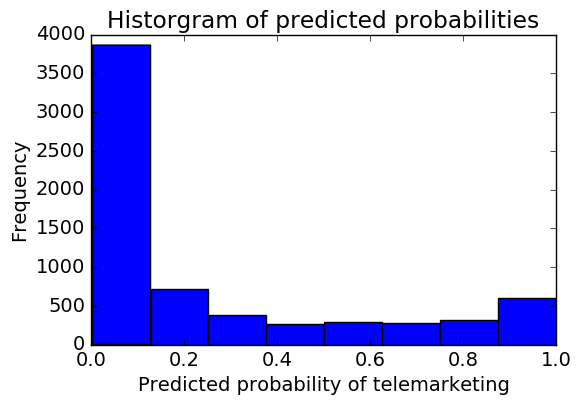

In [31]:
y_pred_prob = logdown.predict_proba(x_val)[:, 1]

plt.rcParams['font.size'] = 14
plt.hist(y_pred_prob, bins = 8)
plt.xlim(0,1)
plt.title("Historgram of predicted probabilities")
plt.xlabel("Predicted probability of telemarketing")
plt.ylabel("Frequency")

In [40]:
#Since we can see highest number of instances have class probability around 0.25, we will set that as a limit, maybe 0.3
y_pred_prob = y_pred_prob.reshape(1,-1)
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob, 0.1)[0]

print (confusion_matrix(y_val, y_pred_class))
print(classification_report(y_val,y_pred_class))

print("Score", roc_auc_score(y_val, y_pred_class))

average_precision = average_precision_score(y_val, y_pred_class)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


precision, recall, thresholds = precision_recall_curve(y_val, classifier.predict_proba(x_val)[:,1])
area = auc(recall, precision)
print("\nArea under precission-recall is:", area)

"""##Computing false and true positive rates
fpr, tpr,_=roc_curve(y_val,y_pred_class,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show() 

"""

[[3544 2429]
 [   5  723]]
             precision    recall  f1-score   support

          0       1.00      0.59      0.74      5973
          1       0.23      0.99      0.37       728

avg / total       0.92      0.64      0.70      6701

Score 0.793234274933
Average precision-recall score: 0.23

Area under precission-recall is: 0.63925180643


"##Computing false and true positive rates\nfpr, tpr,_=roc_curve(y_val,y_pred_class,drop_intermediate=False)\n\nimport matplotlib.pyplot as plt\nplt.figure()\n##Adding the ROC\nplt.plot(fpr, tpr, color='red',\n lw=2, label='ROC curve')\n##Random FPR and TPR\nplt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')\n##Title and label\nplt.xlabel('FPR')\nplt.ylabel('TPR')\nplt.title('ROC curve')\nplt.show() \n\n"

In [61]:
#SVM algorithm

svm_classifier = SVC(kernel = 'linear', random_state = 0)
svm_classifier.fit(x_train, y_train)

predictions_SVC_val = svm_classifier.predict(x_val)
print("Validation set predictions: \n\n" + classification_report(y_val,predictions_SVC_val))

precision, recall, thresholds = precision_recall_curve(y_val, classifier.predict_proba(x_val)[:,1])
area = auc(recall, precision)
print("\nArea under precission-recall is:", area)

#predictions_SVC_test = svm_classifier.predict(x_test)
#print("Test set predictions:\n\n" + classification_report(y_test, predictions_SVC_test))

print("Score", roc_auc_score(y_val, predictions_SVC_val))


Validation set predictions: 

             precision    recall  f1-score   support

          0       0.96      0.90      0.93      5785
          1       0.48      0.70      0.57       727

avg / total       0.91      0.88      0.89      6512


Area under precission-recall is: 0.639173021226
Score 0.801927029896


In [37]:
#KNN Algorithm

knn_classifier = KNeighborsClassifier(n_neighbors=2, metric = 'minkowski', p = 2)
knn_classifier.fit(x_train, y_train)

predictions_KNN_val = knn_classifier.predict(x_val)
print("Validation set predictions: \n\n" + classification_report(y_val,predictions_KNN_val))


average_precision = average_precision_score(y_val, predictions_KNN_val)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, thresholds = precision_recall_curve(y_val, knn_classifier.predict_proba(x_val)[:,1])
area = auc(recall, precision)
print("\nArea under precission-recall is:", area)

#predictions_KNN_test = knn_classifier.predict(x_test)
#print("Test set predictions:\n\n" + classification_report(y_test, predictions_KNN_test))

Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.89      0.91      5973
          1       0.36      0.53      0.43       728

avg / total       0.88      0.85      0.86      6701

Average precision-recall score: 0.24

Area under precission-recall is: 0.474107778096


In [62]:
# Gaussian Naive Bayes
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
# load the iris datasets
# fit a Naive Bayes model to the data
model = GaussianNB()
model.fit(x_train, y_train)
print(model)
# make predictions
predicted = model.predict(x_val)
# summarize the fit of the model
print(metrics.classification_report(y_val, predicted))
print(metrics.confusion_matrix(y_val, predicted))



precision, recall, thresholds = precision_recall_curve(y_val, model.predict_proba(x_val)[:,1])
area = auc(recall, precision)
print("\nArea under precission-recall is:", area)


GaussianNB(priors=None)
             precision    recall  f1-score   support

          0       0.94      0.91      0.92      5785
          1       0.40      0.51      0.45       727

avg / total       0.88      0.86      0.87      6512

[[5238  547]
 [ 358  369]]

Area under precission-recall is: 0.470818272873
